# Pandas
## Data 765 tutoring

[pandas](https://pandas.pydata.org/) is an in memory tabular data frame library written in Python, Cython, and C and builds upon [NumPy](https://numpy.org/). `pandas` loads and manipulates data _in memory_ rather than storing temporary files or loading and operating on chunks. `pandas`' objects are tables that are closer to relational databases (i.e. SQL) than free form and nested objects (i.e. nested JSON or NoSQL). Data are stored as columns rather than rows. Columns are more efficient than rows due to data locality (i.e. what we spoke about in the NumPy mini lecture).

Data frames are omnipresent data structures in data analysis. For example, R ships with a base data frame and also has several libraries that implement alternative data frame. Data frames are more than just abstractions over efficient math. They implement features to ease reshaping data or calculating metrics. For example, exploding a `pandas` DataFrame, joining DataFrames, or aggregating are all made easier by `pandas`.

`pandas` is a general purpose data frame library that fits a wide range of use cases. Other libraries implement specialized data frames that may be optimized for different workloads.

* [Polars](https://www.pola.rs/) is a speedy data frame library written in Rust with Python bindings. Polars is built on [Apache Arrow](https://github.com/apache/arrow-rs), a development framework for in memory data.
* [Apache Spark](https://spark.apache.org/) is designed for distributed, scalable workloads. Spark isn't written in Python, but it has bindings for Python, Scala, Java, R, and others.
* [Dask](https://dask.org/)'s API is similar to `pandas`. `Dask` scales up to clusters but scales down to single machines as well. `Dask` is useful for analyzing big data that don't fit into memory. 
* [datatable](https://github.com/h2oai/datatable) is a data frame library that is similar to R's [data.table](https://rdatatable.gitlab.io/data.table/). `datatable` uses optimized algorithms written in C that are based on `data.table`'s routines.

The above list isn't exhaustive but you get the idea. `pandas` will be your go to library, but you should look into other data frame implementations as needed.

# Data ingestion

Data ingestion is the process of loading data from a source such as a local CSV file.

`pandas`' API is pretty intuitive and easy to use. The API itself is extensive which means that exhaustively covering everything in a few weeks is impossible. Instead, like the class lectures, I'll explain how to navigate and use the API so that you're able to waltz around the docs without feeling utterly overwhelmed.

Speaking of which: [the docs](https://pandas.pydata.org/docs/)

Don't read the docs end to end. Documentation should be purused for specific topics. Libraries usually have quick start guides or longer usage guides that can help with idiomatic use.

I'll use Pokémon [data from Kaggle](https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420) compiled by Mario Tormo as well as Pokémon data I pulled from PokéAPI. Both data sets are mirrored on GitHub.

In [1]:
import pandas as pd
import numpy as np

pokemon = pd.read_csv("../data/pokedex.csv")

`pandas` is typically imported as the alias `pd`. `NumPy` is sometimes imported as well because `pandas` is built on `NumPy` and  it's generally useful to have it around.

The `read_csv()` function loads a comma separated values file into a `DataFrame`. The first parameter is a source which in this case is simply a file path. `read_csv()` has many optional parameters with default arguments. Only the source is required.

You can load several dreadful formats such as Excel, SAS, or SPSS as well as sane formats like CSV, [Parquet](https://en.wikipedia.org/wiki/Apache_Parquet), or [HDF](https://en.wikipedia.org/wiki/Hierarchical_Data_Format).

Generally speaking, you can look up "pandas FILEFORMAT" in your search engine of choice to find the function you need quickly. The documentation also has a [page listing the functions](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html). `pandas` can write to supported formats as well. A general paradigm is to clean up and reshape data then write the table out to a format for reuse. I usually save wrangled data as a flat format for easy sharing and reloading.

`pandas`' I/O is flexible. Local files, remote files, file pointers, et cetera can be used to ingest data. For example, you can load the data I scraped for my thesis right from GitHub without saving a local copy.

In [ ]:
gamers_path = "https://raw.githubusercontent.com/joshuamegnauth54/GamerDistributionThesis2020/master/data/gamers_reddit_medium_2020.csv"
gamers = pd.read_csv(gamers_path)

Or you can execute a SQL query on a server and create a DataFrame from the result.

Don't run this cell because the connection will fail. And don't worry if the SQL doesn't make sense.

In [ ]:
import psycopg2

with psycopg2.connect(database="pokemon", 
                      user="joshua",
                      password="fakepasswordilikecats",
                      host="localhost",
                      port="20000") as conn:
    
    query = """
            WITH pokemon_high_offense(species,
                          id,
                          base_stats,
                          ptype,
                          sp_atk,
                          sp_def,
                          atk,
                          def,
                          speed,
                          hp)
            AS (
                SELECT species,
                       id,
                       base_stats,
                       sp_atk,
                       sp_def,
                       atk,
                       def,
                       speed,
                       hp
                FROM pokemon
                WHERE (sp_atk >= percentile_cont(.5) WITHIN GROUP (ORDER BY sp_atk))
                       OR 
                       (atk >= percentile_cont(.5) WITHIN GROUP (ORDER BY atk))
                )
            SELECT *
            FROM pokemon_high_offense;
            """
    poke_hi_off = pd.read_sql(query, conn)

Each of these I/O functions have many parameters to tweak the ingestion process. For example, [pd.read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) supports:

* `delimiter`: providing a delimiter in case the engine fails to detect one
* `header`: specifying a different row to use as the header (column names)
* `names`: set column names
* `index_col`: column to use an index
* `usecols`: keep specific columns
* Parameters for parsing dates.

And **much** more. You should definitely take a look at the function docs for loading data as you will invariably have to specify parameters in the future.

# Series and DataFrames
[Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) and [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) are `pandas`' main data structures. `DataFrames` consist of `Series`. `Series` are one dimensional ndarrays with additional exposed features to ease data ops.

`DataFrame`, as the documentation mentions, is a container for one or more `Series`. `DataFrame`s are more than a collection of ndarrays or `Series`. Recall the simple table example from the [data structures](https://github.com/joshuamegnauth54/data765-intro-python-tutoring/blob/main/notebooks/02-collections_basics.ipynb) mini-lecture. The code involved nested `list`s that were unwieldly for calculations.

`DataFrame`s ease working with a similiar structure. For example, how would you calculate row-wise or column-wise statistics? You'd have to traverse a nested `list` by row or row and column in other to calculate a mean. This gets messy fast. Now imagine group bys, handling nulls, converting types, pivots, et cetera. `DataFrame`s provide an abstraction over common as well as advanced operations.

`pandas` is built off of `NumPy`. `NumPy` provides efficient iterators for traversing different dimensions of an ndarray as well as features for fast math calculations. Why use `pandas` over `NumPy`? Features like the above are largely more data analysis focussed and thus better off in `pandas`. `pandas` is easier to use for data analysis than working with raw arrays.

## Attributes

From here on out almost everything applies to both `Series` and `DataFrame`s with the stipulation that a method called on a `Series` would only apply to that one object.

`Series` and `DataFrame`s both have properties similar to `NumPy`'s `ndarray`.

In [2]:
print(f"ndim: {pokemon.ndim}")
print(f"shape: {pokemon.shape}")
print(f"size: {pokemon.size}")
print(f"dtypes: {pokemon.dtypes}")

ndim: 2
shape: (1028, 51)
size: 52428
dtypes: Unnamed: 0            int64
pokedex_number        int64
name                 object
german_name          object
japanese_name        object
generation            int64
status               object
species              object
type_number           int64
type_1               object
type_2               object
height_m            float64
weight_kg           float64
abilities_number      int64
ability_1            object
ability_2            object
ability_hidden       object
total_points        float64
hp                  float64
attack              float64
defense             float64
sp_attack           float64
sp_defense          float64
speed               float64
catch_rate          float64
base_friendship     float64
base_experience     float64
growth_rate          object
egg_type_number       int64
egg_type_1           object
egg_type_2           object
percentage_male     float64
egg_cycles          float64
against_normal      float64
ag

These properties are less useful than they are with `ndarrays`. `ndim` is `2` because `pokemon` is a two dimensional table. The `shape` attribute shows (rows, columns).

`DataFrame`s have attributes and functions that are less "raw" than the above. For example, [DataFrame.columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns an array-like data structure that contains the names of all of the columns. Similarly, the `index` attribute returns the index. Both attributes are mutable, but you have to replace them wholesale rather than in pieces. In other words, you can only replace all of the column names at once.

In [3]:
pokemon.columns

Index(['Unnamed: 0', 'pokedex_number', 'name', 'german_name', 'japanese_name',
       'generation', 'status', 'species', 'type_number', 'type_1', 'type_2',
       'height_m', 'weight_kg', 'abilities_number', 'ability_1', 'ability_2',
       'ability_hidden', 'total_points', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship',
       'base_experience', 'growth_rate', 'egg_type_number', 'egg_type_1',
       'egg_type_2', 'percentage_male', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fight', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', 'against_dragon', 'against_dark', 'against_steel',
       'against_fairy'],
      dtype='object')

`head()` and `tail()` show the first five rows of your frame or `Series`. You can pass a number as an argument to view more rows as well.

In [4]:
pokemon.head()

,Unnamed: 0,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,0,1,Bulbasaur,Bisasam,フシギダネ (Fushigidane),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,1,2,Ivysaur,Bisaknosp,フシギソウ (Fushigisou),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,2,3,Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,3,3,Mega Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
4,4,4,Charmander,Glumanda,ヒトカゲ (Hitokage),1,Normal,Lizard Pokémon,1,Fire,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5


`info()` returns operational information about the `DataFrame` such as the type information and null counts.

In [5]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1028 non-null   int64  
 1   pokedex_number    1028 non-null   int64  
 2   name              1028 non-null   object 
 3   german_name       938 non-null    object 
 4   japanese_name     938 non-null    object 
 5   generation        1028 non-null   int64  
 6   status            1028 non-null   object 
 7   species           1028 non-null   object 
 8   type_number       1028 non-null   int64  
 9   type_1            1028 non-null   object 
 10  type_2            542 non-null    object 
 11  height_m          1028 non-null   float64
 12  weight_kg         1027 non-null   float64
 13  abilities_number  1028 non-null   int64  
 14  ability_1         1025 non-null   object 
 15  ability_2         513 non-null    object 
 16  ability_hidden    810 non-null    object 


`info()` is a great way to confirm the types and missingness of your data. You should confirm that the integers are integers and that categoricals are strings/[Categorical](https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html)/`object`s. You should also parse dates in order to leverage the full power of `NumPy`'s `datetime64` type. Your analysis could break if your type information is wrong.

[Renaming](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html) or [dropping](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) rows or columns is useful to pare down your data set.

Both of these have several parameters that I won't go over in much detail (like all of the functions mentioned thus far). `drop()` accepts index or column labels and works with hierarchial indices as well. I set the parameter `inplace` to `True` to modify the original `DataFrame` rather than returning a copy.

In [6]:
pokemon.drop(columns=["Unnamed: 0",
                      "german_name",
                      "japanese_name",
                      "abilities_number",
                      "type_number"],
            inplace=True)

You should drop columns as early as possible or load specific variables using `read_csv()`. Many data sets ship with more rows or columns that can comfortably analyzed with the median machine. In other words, loading medium sized or larger data sets take up a lot of RAM and that can balloon with operations such as group by. `pandas` loads everything into memory while specialized data frames may not as discussed earlier.

I dropped a mangled column, "Unnamed: 0", and Pokémon names in Japanese and German. I also dropped two columns which indicate the number of types and abilities for a Pokémon species.

# Type conversion

Python is dynamically and strongly typed. Dynamic typing means that Python variables aren't checked for types during a compilation phase or before a script is run.

In [7]:
a = 5
a = "5"
a = 5.

The variable `a` can be bound to objects of multiple different types as the script executes. Strong typing means that types rarely "morph" during execution. A string is a string and doesn't implicitly convert to a number unless explicitly requested. Python lacks unsafe tricks to treat a type as a different type without checks.

In other words this will fail:

In [8]:
"5" + 5

TypeError: can only concatenate str (not "int") to str

Certain operations are only available on specific types. We can't add a string and an integer by default without converting the integer to a string as well. Python automatically converts certain types though. Integers are converted to float when necessary for example.

`pandas` attempts to automatically detect types during parsing. However, `pandas` can only do so much. Let's say you have a column that should be all numbers but the data set has erroneous observations. For example `[1024, 2048, 40()96]`. `pandas` would parse this as a string because the last value cannot be coerced to an integer. You should check that your `DataFrame`'s types are what you expect. I've personally witnessed students run into errors due to mangled types.

Recently, the `pandas` team implemented a new `string` which is more efficient than storing text as `object`s. A new nullable `Int64` type replaces the old integer dtype. Previously, integer columns with `nan`s would parse as `float64`. As the lecture notes mention, you don't have to worry too much about these types just yet.

[DataFrame.astype](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) is used to convert types.

In [9]:
pokemon = pokemon.astype({"name": "string",
                          "status": "category",
                          "species": "string",
                          "type_1": "category",
                          "type_2": "category",
                          "ability_1": "category",
                          "ability_2": "category"
                         })

The documentation lists [valid dtypes here](https://numpy.org/doc/stable/reference/arrays.dtypes.html). You should make sure that floats and integers are properly parsed. Nominal variables that are coded as integers should be recoded or at least converted to the `Categorical` type so that they aren't accidentally treated as numbers.

The `Categorical` type is useful for variables with a lot of repetition such as gender or in this case types and abilities.

In [10]:
pokemon.type_1.value_counts()

Water       134
Normal      115
Grass        91
Bug          81
Psychic      76
Fire         65
Electric     61
Rock         60
Dark         44
Ghost        41
Ground       41
Dragon       40
Poison       39
Fighting     38
Ice          36
Steel        36
Fairy        22
Flying        8
Name: type_1, dtype: int64

While you can keep such columns as `string`s or `object`s, `pandas` stores the `Categorical` type more efficiently than the other types when repetition is high.

`Categorical` is something like an enumeration from other languages.

Besides `value_counts()`, `unique()` or `nunique()` or both useful for finding nominal variables.

In [11]:
pokemon.status.unique()

['Normal', 'Sub Legendary', 'Legendary', 'Mythical']
Categories (4, object): ['Legendary', 'Mythical', 'Normal', 'Sub Legendary']

# Indexation

Filtering for and wrangling the exact data you need is a fundamental task of the data pipeline. For example, you may need to select a subset of observations or specific columns or both. You may wish to calculate an average for a variable based on gender or race or both at once!

Columns may be selected with the dot operator, array styled indexing, as well as the more powerful [.loc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) and [.iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) operators.

In [12]:
print(f"Median special attack: {pokemon.sp_attack.median()}")

# The dot operator...
sp_def_75 = pokemon.sp_defense.quantile(.75)
# ...and bracket operator operate the same here
sp_def_25 = pokemon["sp_defense"].quantile(.25)

# Interquartile range (IQR)
sp_def_iqr = sp_def_75 - sp_def_25

Median special attack: 65.0


The above cell demonstrates two different ways to select columns. The first method uses the `.` operator (dot) to select a column as an attribute. The dot operator looks clean but doesn't work for column names that are invalid Python variable names. The bracket operator always works.

I tend to use the dot operator unless I have to use the bracket operator. I rename columns to be all lowercase as well as valid for the dot operator.

In [13]:
# Notice the column names
no_dot_df = pd.DataFrame({"123nope": np.arange(3),
                          "sp ace": np.arange(3)
                         })

What happens if the dot operator is used to access `123nope`?

In [14]:
# Won't work
no_dot_df.123nope

SyntaxError: invalid syntax (2469122346.py, line 2)

`123nope` doesn't work with the dot operator because it's not a valid variable name. The bracket operator always works.

In [15]:
no_dot_df["sp ace"]

0    0
1    1
2    2
Name: sp ace, dtype: int64

Another limitation is that new columns can't be created with the dot operator. Instead, the dot operator would create a [new attribute](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html).

In [16]:
no_dot_df.cats_are_great = np.arange(3)

/tmp/ipykernel_1750/3708967444.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  no_dot_df.cats_are_great = np.arange(3)


`pandas` raises a warning so there's no worry here. The bracket operator works as intended of course.

In [17]:
no_dot_df["cats_are_great"] = np.arange(3)

Anywho, I calculate two percentiles after selecting `sp_def` and then use those values to calculate an interquartile range.

# `loc` and `iloc`

A common but simple metric for outlier detection is [Tukey](https://en.wikipedia.org/wiki/John_Tukey)'s IQR rule. Tukey (and his box plot) label outliers as values above the third quantile plus 1.5 times the IQR or below the first quantile minus 1.5 times the IQR.

The bracket operator supports fancy indexing which allows us to select the rows containing outliers.

In [18]:
sp_def_iqr_rule = 1.5 * sp_def_iqr
sp_def_iqr_lower = pokemon.sp_defense.quantile(.25) - sp_def_iqr_rule
sp_def_iqr_upper = pokemon.sp_defense.quantile(.75) + sp_def_iqr_rule

pokemon[(pokemon.sp_defense > sp_def_iqr_upper) | (pokemon.sp_defense < sp_def_iqr_lower)]

,pokedex_number,name,generation,status,species,type_1,type_2,height_m,weight_kg,ability_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
256,213,Shuckle,2,Normal,Mold Pokémon,Bug,Rock,0.6,20.5,Sturdy,...,1.0,1.0,1.0,1.00,2.0,1.0,1.0,1.0,2.0,1.0
296,249,Lugia,2,Legendary,Diving Pokémon,Psychic,Flying,5.2,216.0,Pressure,...,0.0,1.0,0.5,1.00,2.0,2.0,1.0,2.0,1.0,1.0
297,250,Ho-oh,2,Legendary,Rainbow Pokémon,Fire,Flying,3.8,199.0,Pressure,...,0.0,1.0,1.0,0.25,4.0,1.0,1.0,1.0,0.5,0.5
447,378,Regice,3,Sub Legendary,Iceberg Pokémon,Ice,NaN,1.8,175.0,Clear Body,...,1.0,1.0,1.0,1.00,2.0,1.0,1.0,1.0,2.0,1.0
454,382,Primal Kyogre,3,Legendary,Sea Basin Pokémon,Water,NaN,9.8,430.0,Primordial Sea,...,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
462,386,Deoxys Defense Forme,3,Mythical,DNA Pokémon,Psychic,NaN,1.7,60.8,Pressure,...,1.0,1.0,0.5,2.00,1.0,2.0,1.0,2.0,1.0,1.0
778,671,Florges,6,Normal,Garden Pokémon,Fairy,NaN,1.1,10.0,Flower Veil,...,1.0,1.0,1.0,0.50,1.0,1.0,0.0,0.5,2.0,1.0
1027,890,Eternatus Eternamax,8,Legendary,Gigantic Pokémon,Poison,Dragon,100.0,NaN,NaN,...,2.0,1.0,2.0,0.50,1.0,1.0,2.0,1.0,1.0,1.0


The bracket operator returned every column. The output looks super cluttered because it contains variables irrelevant for our query. We can chain bracket operators to return specific columns. Or, better yet, we can use the `.loc` attribute.

`loc[]` and `iloc[]` are required for granular selection. Both operators return a [view rather than a copy](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-view-versus-copy) of your selection which is faster and allows mutation of the original `DataFrame` or `Series`. Using `[]` or chaining `[]` is iffy and should be avoided if you're using them to modify your `DataFrame`. You may think that you're editing your data but in reality you're only modifying a copy. Essentially, whether the bracket operator returns a copy or a view is context dependent. `loc[]` and `iloc[]` are safer as well as faster. More on this later!

`loc` operates on labels such as column names or the values of an index. `iloc` is position based which means you index like you'd retrieve an element from an array.

In [19]:
# Boolean matrix. Creating a separate variable for filtering isn't necessary, but
# it can look cleaner with longer criteria.
sp_def_outliers_bools = (pokemon.sp_defense < sp_def_iqr_lower) | (pokemon.sp_defense > sp_def_iqr_upper)

# The first index is the rows while the second are columns.
sp_def_outliers = pokemon.loc[sp_def_outliers_bools, ("pokedex_number",
                                                      "name",
                                                      "status",
                                                      "type_1",
                                                      "type_2",
                                                      "sp_defense")]

sp_def_outliers

,pokedex_number,name,status,type_1,type_2,sp_defense
256,213,Shuckle,Normal,Bug,Rock,230.0
296,249,Lugia,Legendary,Psychic,Flying,154.0
297,250,Ho-oh,Legendary,Fire,Flying,154.0
447,378,Regice,Sub Legendary,Ice,NaN,200.0
454,382,Primal Kyogre,Legendary,Water,NaN,160.0
462,386,Deoxys Defense Forme,Mythical,Psychic,NaN,160.0
778,671,Florges,Normal,Fairy,NaN,154.0
1027,890,Eternatus Eternamax,Legendary,Poison,Dragon,250.0


`loc` allows easily subsetting by labels. I selected the required columns by label by passing it to `loc`'s second indexer.

The Pokémon above all have special defense that _may_ be outliers according to Tukey's rule. All of these are obvious because the list is dominated by legendary Pokémon and weirdos (Shuckle). A more robust application of Tukey's rule for Pokémon data would calculate the percentiles by primary type, legendary status, evolution stage, or perhaps all. Precluding legendaries altogether is also viable because they're special. More on this later.

Understanding your data is as important as writing code. I arrived at a tautological answer because I didn't control for anything.

## `iloc`

`iloc` selects rows and columns by index rather than labels.

In [20]:
kanto = pokemon.iloc[1:13, 0:3]
kanto.tail()

,pokedex_number,name,generation
8,6,Mega Charizard Y,1
9,7,Squirtle,1
10,8,Wartortle,1
11,9,Blastoise,1
12,9,Mega Blastoise,1


## When to use `[]` over `loc`?
`loc` is more powerful than `[]` while `[]` is more readable.

You can use `[]` if you're simply selecting a subset of columns or performing simple filtering. `loc` should be preferred for more complex queries.

In [21]:
sp_cols = ["name", "sp_attack", "sp_defense"]

# This
sp_def_atk = pokemon[sp_cols]

# Is the same as this
sp_def_atk_oth = pokemon.loc[:, sp_cols]

## SettingWithCopyWarning

As mentioned earlier, `pandas` may return a view or a copy after operations. Modifying a copy instead of the actual `DataFrame` may be confusing especially if you believe that you're modifying the `DataFrame` itself. Certain methods, such as `query()`, always return a copy.

In [22]:
default_rng = np.random.default_rng()

scores = pd.DataFrame({
     "id": np.arange(1, 21),
     "score": default_rng.normal(5., 10., 20)
})

`scores` is a `DataFrame` of video game scores. Neat! Unfortunately, a few mooks cheated. According to _Really Awesome Anticheat,_ id numbers 2, 5, 12, 16, and 19 cheated. The mooks! Let's set those scores to `nan`..._the wrong way!_

In [23]:
mooks = [2, 5, 12, 16]
scores[scores.id.isin(mooks)]["score"] = np.nan

/tmp/ipykernel_1750/3992973904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[scores.id.isin(mooks)]["score"] = np.nan


`pandas` warns us about mutating a copy and even suggests `loc`.

In [24]:
scores

,id,score
0,1,23.387347
1,2,13.267547
2,3,-1.404804
3,4,14.235318
4,5,-10.092700
5,6,1.862627
6,7,-2.607643
7,8,15.048285
8,9,-3.549692
9,10,-4.446245


The values for the filthy cheaters remain the same. Now with `loc`:

In [25]:
scores.loc[scores.id.isin(mooks), "score"] = np.nan
scores

,id,score
0,1,23.387347
1,2,NaN
2,3,-1.404804
3,4,14.235318
4,5,NaN
5,6,1.862627
6,7,-2.607643
7,8,15.048285
8,9,-3.549692
9,10,-4.446245


## `loc[]` with a function
`loc[]` can be passed a function, including lambdas, for filtering. The function should return a boolean vector and accept a `DataFrame` and/or `Series` as appropriate.

In [26]:
def iqr(features):
     """Calculate IQR for a Series or DataFrame

     Parameters
     ----------
     features: Union[pd.Series, pd.DataFrame]
          Series or DataFrame for which to calculate IQR(s).

     Returns
     -------
     Union[float, pd.DataFrame]
          Returns the IQR as a float or IQRs as a DataFrame.
     """
     quantiles = features.quantile([.25, .75])
     return quantiles.loc[0.75] - quantiles.loc[0.25]

def iqr_rule(features):
     """Construct boolean array(s) for outliers via Tukey's rule.

     Parameters
     ----------
     features: Union[pd.Series, pd.DataFrame]
          Series or DataFrame for which to construct boolean arrays.

     Returns
     -------
     Union[pd.Series, pd.DataFrame]
          Boolean arrays for outliers.
     """
     iqr_rule = 1.5 * iqr(features)
     iqr_lower = features.quantile(.25) - iqr_rule
     iqr_upper = features.quantile(.75) + iqr_rule

     return ((features < iqr_lower) | (features > iqr_upper)).any(axis="columns")

# And to test...
poke_stats = pokemon[["total_points",
                      "hp",
                      "attack",
                      "defense",
                      "sp_attack",
                      "sp_defense",
                      "speed"]]

# iqr_rule can be passed straight to loc
poke_stats.loc[iqr_rule].head(20)

,total_points,hp,attack,defense,sp_attack,sp_defense,speed
53,435.0,140.0,70.0,45.0,85.0,50.0,45.0
84,600.0,55.0,50.0,65.0,175.0,105.0,150.0
105,590.0,95.0,75.0,180.0,130.0,80.0,30.0
119,525.0,50.0,95.0,180.0,85.0,45.0,70.0
123,600.0,60.0,65.0,80.0,170.0,95.0,130.0
124,385.0,35.0,45.0,160.0,30.0,45.0,70.0
145,450.0,250.0,5.0,5.0,35.0,105.0,50.0
167,535.0,130.0,85.0,80.0,85.0,95.0,60.0
171,525.0,130.0,65.0,60.0,110.0,95.0,65.0
181,540.0,160.0,110.0,65.0,65.0,110.0,30.0


## Query
Did I mention that `pandas` has a lot of features yet? The `query()` method takes a string for queries. `query()` looks delightfully laconic compared to long boolean array queries.

In [27]:
pokemon.query("sp_attack > 130 or sp_defense > 130")

,pokedex_number,name,generation,status,species,type_1,type_2,height_m,weight_kg,ability_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
8,6,Mega Charizard Y,1,Normal,Flame Pokémon,Fire,Flying,1.7,100.5,Drought,...,0.0,1.0,1.0,0.25,4.00,1.0,1.0,1.0,0.5,0.5
12,9,Mega Blastoise,1,Normal,Shellfish Pokémon,Water,NaN,1.6,101.1,Mega Launcher,...,1.0,1.0,1.0,1.00,1.00,1.0,1.0,1.0,0.5,1.0
23,18,Mega Pidgeot,1,Normal,Bird Pokémon,Normal,Flying,2.2,50.5,No Guard,...,0.0,1.0,1.0,0.50,2.00,0.0,1.0,1.0,1.0,1.0
83,65,Alakazam,1,Normal,Psi Pokémon,Psychic,NaN,1.5,48.0,Synchronize,...,1.0,1.0,0.5,2.00,1.00,2.0,1.0,2.0,1.0,1.0
84,65,Mega Alakazam,1,Normal,Psi Pokémon,Psychic,NaN,1.2,48.0,Trace,...,1.0,1.0,0.5,2.00,1.00,2.0,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,858,Hatterene,8,Normal,Silent Pokémon,Psychic,Fairy,2.1,5.0,Healer,...,1.0,1.0,0.5,1.00,1.00,2.0,0.0,1.0,2.0,1.0
995,864,Cursola,8,Normal,Coral Pokémon,Ghost,NaN,1.0,0.4,Weak Armor,...,1.0,1.0,1.0,0.50,1.00,2.0,1.0,2.0,1.0,1.0
1024,889,Zamazenta Crowned Shield,8,Legendary,Warrior Pokémon,Fighting,Steel,2.9,785.0,Dauntless Shield,...,2.0,1.0,1.0,0.25,0.25,1.0,0.5,0.5,0.5,1.0
1026,890,Eternatus,8,Legendary,Gigantic Pokémon,Poison,Dragon,20.0,950.0,Pressure,...,2.0,1.0,2.0,0.50,1.00,1.0,2.0,1.0,1.0,1.0


# Nulls
Missingness is a huge topic in data science. Missing values can hamper your analysis depending on the study. For example, if your dependent variable is largely missing then you can neither do inference nor prediction. Observations may be [systematically missing](https://stefvanbuuren.name/fimd/sec-MCAR.html).

Data may be **missing at random (MAR)**, **missing completely at random (MCAR)**, or **missing not at random (MNAR).** Missing at random refers to observations that are missing due to some other factor in the data. For example, secondary type (`type_2`) and `ability_2` are missing at random. Many Pokémon don't have secondary types or second abilities. Thus, those observations are MAR because the missingness is accounted by the data. MCAR are observations that are missing without any pattern.

MCAR is generally perfectly fine and MAR is fine as well. MNAR is a problem. Values that are MNAR are missing by virtue of what is studied. MNAR isn't relevant for Pokémon data, so I'll use a different example. Let's say you're interested in studying undocumented immigrants or criminals. Unfortunately, the variables indicating undocumented status or the crime committed were missing for the people at hand. In other words, if undocumented immigrants largely skipped citizenship questions then that data are MNAR. You can't adequately perform a study with MNAR data.

Imputation is possible but care needs to be taken that you're not introducing bias. Some techniques, such as mean imputation, are entirely useless. Imputation is out of the scope of this Notebook, but I'd like to to demonstrate why mean imputation is useless at least.

Also by _useless_ I mean _useless_. Just don't do mean imputation, ever.

In [28]:
# Parameters
x_mu = 4
x_std = 2
x_size = 100
x_del_size = 15
fx_constant = 0.5

# Random x
x_vm = default_rng.vonmises(x_mu, x_std, x_size)
# And f(x)
y_vm = x_vm + default_rng.normal(x_mu, x_std, x_size) + fx_constant

# Delete some random observations
delete = default_rng.choice(np.arange(x_size), x_del_size)
x_vm_actual = x_vm[delete]
x_vm[delete] = np.nan

# Impute missing values as mean of x_vm
x_vm[delete] = np.nanmean(x_vm)

The code above creates a random variable, `x_vm`, and a `y` which is a function of `x_vm`. I delete random values then assign the mean of the reduced vector to those missing values.

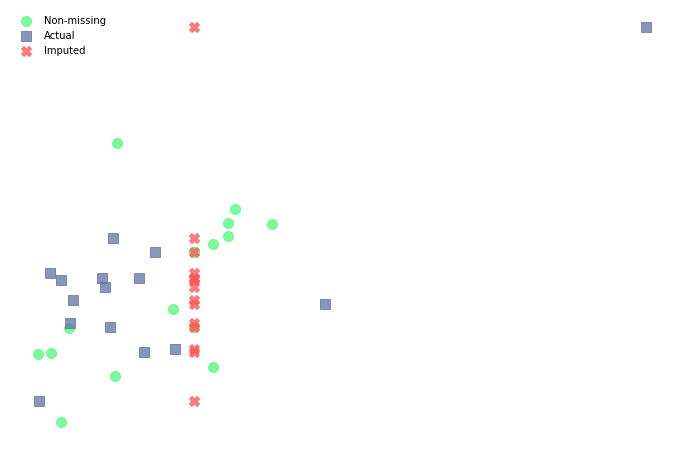

In [29]:
import matplotlib.pyplot as plt

# Colors, size
size = 100
alpha = .75
green = "#50fa7b"
blue = "#6272a4"
red = "#ff5555"

fig_na, ax_na = plt.subplots(figsize=(12, 8))

# Deleted points in blue and imputed in red
ax_na.scatter(x_vm[~delete], y_vm[~delete],
              c=green,
              s=size,
              alpha=alpha,
              label="Non-missing")
ax_na.scatter(x_vm_actual, y_vm[delete],
              c=blue,
              marker='s',
              s=size,
              alpha=alpha,
              label="Actual")
ax_na.scatter(x_vm[delete], y_vm[delete],
              c=red,
              marker='X',
              s=size,
              alpha=alpha,
              label="Imputed")

# Minimalist graph
ax_na.legend(frameon=False)
ax_na.set_axis_off()

The line of red Xes are the imputed values while the blue squares are the deleted values.

Notice that the imputed values don't vary at all because they're just one number. Secondly, the mean only accounts for present values, so it is biased in terms of the observed rather than accounting for the full data. Mean imputed values only add in bias which is worse than having nulls.

## But what to do about nulls!

Nothing? The main issue is to ensure nulls are properly coded as `np.nan` (or the new experimental `nan`). In other words, sometimes data sets code nulls as magic number, such as -999. You should replace magic number nulls with `np.nan`.

Imputation is possible with robust algorithms and understanding your data. Beyond that you should leave nulls in and report their existence. You only have to explicitly drop nulls if an algorithm or plot fails with `nans` (i.e. machine learning implementations that don't automatically drop nulls).

# Group by, aggregation, and pivot tables

Group bys and aggregation is where the real fun begins. Group by calculates a statistic across a certain variable, usually a categorical. This is useful for exploring the data across subsets instead of reducing the entire data set to one number. For example, calculating mean income over subsets such as industry and sex makes more sense than calculating a single average for a data set.

In [30]:
pokemon.groupby("type_1")[["attack", "sp_attack"]].mean()

,attack,sp_attack
type_1,,
Bug,71.074074,56.382716
Dark,81.000000,70.454545
Dragon,107.200000,91.525000
Electric,74.573770,89.377049
Fairy,68.090909,78.954545
Fighting,101.263158,56.421053
Fire,85.400000,86.415385
Flying,75.125000,73.875000
Ghost,74.195122,81.975610


Group by can also be applied to multiple dimensions for more complex queries.

In [31]:
pokemon.groupby(["generation", "status"]).size()

generation  status       
1           Legendary          3
            Mythical           1
            Normal           185
            Sub Legendary      3
2           Legendary          2
            Mythical           1
            Normal           101
            Sub Legendary      3
3           Legendary          6
            Mythical           5
            Normal           147
            Sub Legendary      7
4           Legendary          4
            Mythical           6
            Normal           105
            Sub Legendary      6
5           Legendary          5
            Mythical           6
            Normal           151
            Sub Legendary      9
6           Legendary          5
            Mythical           5
            Normal            75
            Sub Legendary      0
7           Legendary          8
            Mythical           5
            Normal            69
            Sub Legendary     17
8           Legendary          6
            Mythi

The new index above is now a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html). `MultiIndex`es are indexed using `loc[]` and `tuple`s. Within the `tuple` are elements corresponding to each dimension.

In [32]:
type_combos = pokemon.groupby(["type_1", "type_2"]).size()
type_combos.head(15)

type_1  type_2  
Bug     Bug          0
        Dark         0
        Dragon       0
        Electric     4
        Fairy        2
        Fighting     4
        Fire         2
        Flying      14
        Ghost        1
        Grass        6
        Ground       2
        Ice          0
        Normal       0
        Poison      12
        Psychic      2
dtype: int64

What a mess! I counted the combination of primary and secondary types using a group by. The resulting table is an intractable albeit useful mess. I'll demonstrate a better way to approach this in a bit.

Slicing with `loc` and a `tuple` first selects `type_1` followed by `type_2`.

In [33]:
psy_fairy = type_combos.loc[("Psychic", "Fairy")]
print(f"There are {psy_fairy} Psychic-Fairy Pokémon.")

There are 9 Psychic-Fairy Pokémon.


The outer layer of the index can be accessed without the `tuple`. For example, retrieving the combinations for the primary type "Dragon" is as simple as:

In [34]:
type_combos["Dragon"].head()

type_2
Bug         0
Dark        0
Dragon      0
Electric    1
Fairy       1
dtype: int64

Slicing works for every layer. The outer layer is sliced as `start: end` with `end` included as is customary for `pandas`.

In [35]:
type_combos["Dark":"Grass"]

type_1  type_2  
Dark    Bug          0
        Dark         0
        Dragon       4
        Electric     0
        Fairy        3
                    ..
Grass   Poison      15
        Psychic      2
        Rock         0
        Steel        3
        Water        0
Length: 162, dtype: int64

Inner layers need `loc` and `tuple`s for more complicated slicing.

In [36]:
type_combos.loc[("Electric", "Fire"): ("Ground", "Normal")]

type_1    type_2
Electric  Fire      1
          Flying    6
          Ghost     1
          Grass     1
          Ground    0
                   ..
Ground    Ghost     4
          Grass     0
          Ground    0
          Ice       0
          Normal    0
Length: 133, dtype: int64

## Pivot tables

[Pivot tables](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) are generalized group bys. The group bys above can all be represented as pivot tables.

The three main parameters for pivot tables are `values`, `index`, and `columns`. `index` and `columns` are the grouper variables while `values` is the aggregated feature. Besides those three parameters, you can pass a function to use as an aggregator and whether marginal totals should be calculated.

In [37]:
type_table = pokemon.pivot_table(values="name",
                                 index="type_1",
                                 columns="type_2",
                                 aggfunc="count")

type_table

type_2,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
type_1,,,,,,,,,,,,,,,,,,
Bug,0,0,0,4,2,4,2,14,1,6,2,0,0,12,2,3,7,3
Dark,0,0,4,0,3,2,3,5,2,0,0,2,5,0,2,0,2,0
Dragon,0,0,0,1,1,2,1,6,3,0,7,3,0,0,4,0,0,0
Electric,0,2,2,0,2,0,1,6,1,1,0,2,2,3,1,0,4,1
Fairy,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0
Fighting,0,1,0,0,0,0,0,1,1,0,0,1,0,0,3,0,3,0
Fire,2,1,2,0,0,7,0,7,2,0,3,0,2,0,2,1,1,1
Flying,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
Ghost,0,1,2,0,1,0,3,3,0,11,2,0,0,4,0,0,0,0


The final result is much easier to read. Multiple variables can be passed to the groupers, but the table becomes much harder to read as variables are added. Prudence is important here.

[Next: exploratory data analysis](https://github.com/joshuamegnauth54/data765-intro-python-tutoring/blob/main/notebooks/09-eda.ipynb)